In [1]:
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import random

In [2]:
pcd = o3d.io.read_point_cloud("point_cloud.pcd")
# o3d.visualization.draw_geometries([pcd])

In [3]:
def projectToImage(K, P, points, colors, height, width):
    R = P[:, :3]
#     R[:, 1] *= -1
    t = P[:, 3]
    
    dist_coeff = np.zeros((4, 1))
    projected, _ = cv2.projectPoints(points, R, t, K, dist_coeff)
    projected = projected.reshape(-1, 2). astype(np.int)
    
    mask = (
        (0 <= projected[:, 0]) & (projected[:, 0] < width) &
        (0 <= projected[:, 1]) & (projected[:, 1] < height)
    )
    
    img_coord = projected[mask]
    img_color = colors[mask]
    
    return img_coord, img_color

In [4]:
def getPoses():
    poses = []
    with open("poses.txt","r") as f:
        lines = f.readlines()
        for line in lines:
            row = line.split(" ")
            row = np.array(row).astype('float64')
            poses.append(row.reshape((3, 4)))

    return poses

In [5]:
def getImage(points, color, height, width):
    image = np.zeros((height, width, 3), dtype=color.dtype)
    image[points[:, 1], points[:, 0]] = color
    return image

In [47]:
def DLT(world_points, image_points, k):
    A = []
    for i in range(k):
        u = image_points[i][0]
        v = image_points[i][1]
        x = world_points[i][0]
        y = world_points[i][1]
        z = world_points[i][2]
        row_1 = [0, 0, 0, 0, -x, -y, -z, -1, v*x, v*y, v*z, v]
        row_2 = [x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z, -u]
        row_3 = [-v*x, -v*y, -v*z, -v, u*x, u*y, u*z, u, 0, 0, 0, 0]
        A.extend([row_1, row_2, row_3])
    A = np.array(A)
    
    u, s, vh = np.linalg.svd(A, full_matrices=False)
    
    print(u.shape, s.shape, vh.shape)
    vh = vh.transpose()
#     print(vh)
    P = vh[:, 11]
    P = P.reshape(3,4)
    print(A.shape)
    
    return P
    

In [6]:
# P = np.array([-9.466844e-01, 2.747540e-02, 3.209888e-01, -1.869050e+02, 3.735473e-02, 9.989978e-01, 2.465901e-02, 1.925132e+00, -3.199896e-01, 3.533474e-02, -9.467619e-01, 4.724980e+01])
# P = np.reshape(P, (3, 4))
poses = getPoses()
P = poses[0]
K = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02], [0.000000e+00, 7.070912e+02, 1.831104e+02], [0.000000e+00, 0.000000e+00, 1.000000e+00]])
height = 370
width = 1226

In [7]:
points = np.asarray(pcd.points) 
colors = np.asarray(pcd.colors)

print(points.shape)

(1090706, 3)


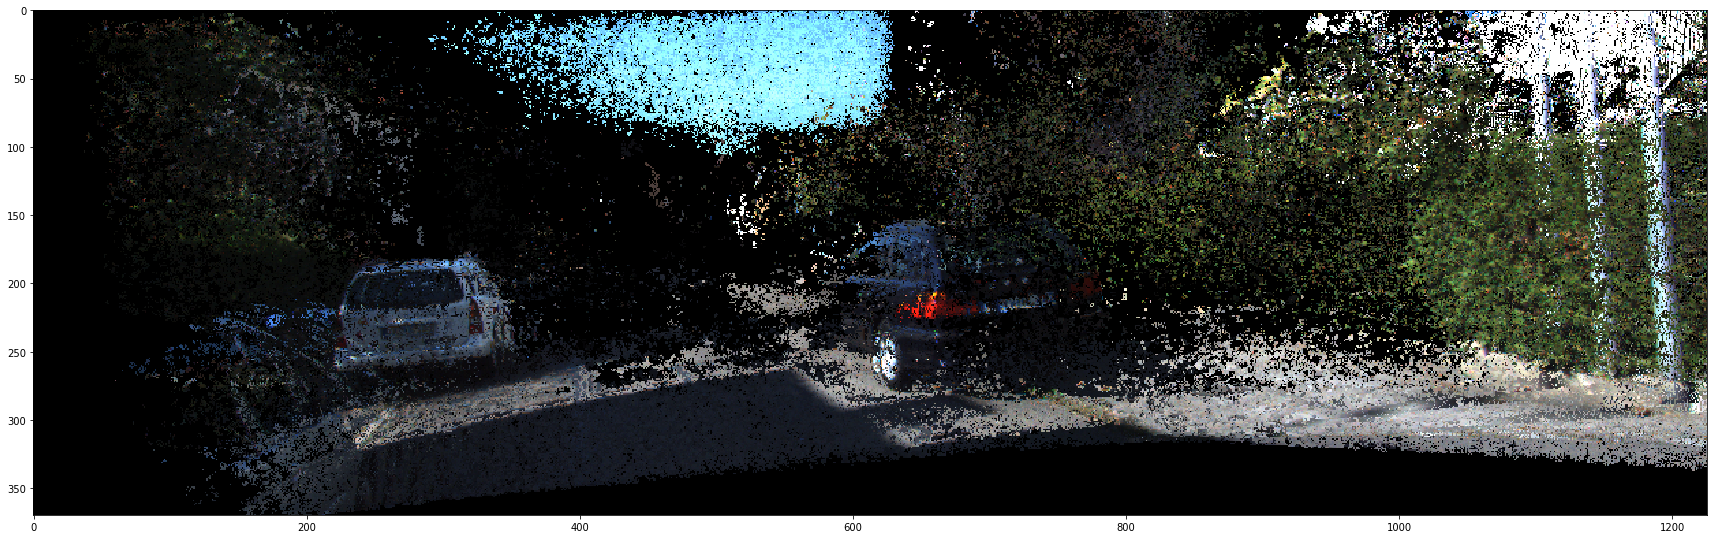

In [8]:
img_coord, img_color = projectToImage(K, P, points, colors, height, width)
img = getImage(img_coord, img_color, height, width)

plt.subplots_adjust(right=4, top=4)
plt.imshow(img)
plt.show()

In [39]:
k = 50
sampling = np.array(random.choices(points, k=k))
# print(sampling.shape)
row = np.ones((k, 1))
# print(sampling.shape, row.shape)
sampling = np.concatenate([sampling, row], axis = 1)
sampled_image = (K @ P @ sampling.T).T
# print(sampled_image.shape, sampled_image[:, 2].shape)

for i in range(k):
    sampled_image[i] /= sampled_image[i, 2]

print(sampling.shape)
print(sampled_image.shape)

# print(sampled_image)

(50, 4)
(50, 3)


In [49]:
# x x PX = 0
print(P/P[2][3])
P_calc = DLT(sampling, sampled_image, k)
P_calc = np.linalg.inv(K) @ P_calc 
print(P_calc/P_calc[2][3])

[[ 2.61081535e+03 -2.23201752e+03  6.51289448e+03 -8.47468368e+01]
 [-7.48733455e+02 -5.08631994e+03  8.48086234e+02  1.73724388e+02]
 [-2.87981215e+00 -2.33203039e+00  5.54911276e+00  1.00000000e+00]]
(150, 12) (12,) (12, 12)
(150, 12)
[[ 2.61081519e+03 -2.23201739e+03  6.51289409e+03 -8.47468318e+01]
 [-7.48733410e+02 -5.08631964e+03  8.48086183e+02  1.73724378e+02]
 [-2.87981197e+00 -2.33203025e+00  5.54911243e+00  1.00000000e+00]]
